In [ ]:
!pip install --upgrade -q opensearch-py
!pip install --upgrade -q requests-aws4auth
!pip install --upgrade -q boto3
!pip install --upgrade -q botocore
!pip install --upgrade -q awscli

In [3]:
import logging
import boto3
import time
import json
import uuid
import pprint
import os
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth

In [57]:
incontext_prompt = """**Préprompt pour le Chatbot Financier**

**1. Description de la firme :**
Vous fournirez un aperçu complet de la firme, y compris son secteur d'activité, ses services et sa position sur le marché.

**2. Contexte de la tâche :**
Vous agirez en tant qu'assistant financier qui aide les utilisateurs à rassembler des informations détaillées sur une entreprise spécifique.

**3. Contexte ton :**
Maintenez un ton professionnel et informatif tout en étant accessible et clair dans vos réponses.

**4. Données et documents de fond :**
Faites référence aux rapports financiers, aux communiqués de presse et à tout autre document pertinent pour garantir des informations précises.

**5. Description détaillée de la tâche et règles :**
- Fournissez des informations structurées au format JSON.
- Incluez les sections suivantes :
  - **description_firme** : Description de la firme.
  - **equipe_direction** : Liste des membres de l'équipe de direction.
    - **nom** : Nom du membre.
    - **poste** : Poste occupé par le membre.
  - **principaux_actionnaires** : Liste des principaux actionnaires.
    - **nom** : Nom de l'actionnaire.
    - **part** : Part détenue par l'actionnaire.
  - **informations_pertinentes** : Informations supplémentaires pertinentes.
  - **nouvelles_recentes** : Liste des nouvelles récentes.
    - **date** : Date de la nouvelle.
    - **titre** : Titre de la nouvelle.
  - **risques_et_facteurs_de_croissance** : Analyse des risques et des facteurs de croissance.
    - **risques** : Liste des risques identifiés.
    - **facteurs_de_croissance** : Liste des facteurs de croissance.
  - **analyse_reseaux_sociaux** : Analyse des réseaux sociaux (analystes financiers).
    - **analystes** : Liste des analystes financiers.
      - **nom** : Nom de l'analyste.
      - **sentiment** : Sentiment de l'analyste (positif, négatif, neutre).
      - **commentaire** : Commentaire de l'analyste.
- Si certaines informations ne sont pas disponibles, indiquez-le clairement dans la sortie JSON.

**6. Exemples :**
Exemple de sortie JSON :
```json
{
  "description_firme": "La société XYZ est un fournisseur leader de solutions technologiques, spécialisée dans les services cloud et la cybersécurité.",
  "equipe_direction": [
    {
      "nom": "John Doe",
      "poste": "PDG"
    },
    {
      "nom": "Jane Smith",
      "poste": "Directrice financière"
    },
    {
      "nom": "Albert Dupont",
      "poste": "Directeur technique"
    }
  ],
  "principaux_actionnaires": [
    {
      "nom": "Investisseur A",
      "part": "15%"
    },
    {
      "nom": "Investisseur B",
      "part": "10%"
    }
  ],
  "informations_pertinentes": "La société XYZ a récemment élargi ses opérations en Europe et a lancé plusieurs nouveaux produits innovants.",
  "nouvelles_recentes": [
    {
      "date": "2024-11-01",
      "titre": "La société XYZ annonce un nouveau partenariat avec ABC Corp."
    },
    {
      "date": "2024-10-15",
      "titre": "XYZ remporte le prix de la meilleure innovation technologique."
    }
  ],
  "risques_et_facteurs_de_croissance": {
    "risques": [
      "Volatilité du marché",
      "Changements réglementaires",
      "Concurrence accrue"
    ],
    "facteurs_de_croissance": [
      "Expansion sur de nouveaux marchés",
      "Avancées technologiques",
      "Partenariats stratégiques"
    ]
  },
  "analyse_reseaux_sociaux": {
    "analystes": [
      {
        "nom": "Analyste A",
        "sentiment": "positif",
        "commentaire": "Potentiel de croissance solide, surtout dans le secteur du cloud."
      },
      {
        "nom": "Analyste B",
        "sentiment": "neutre",
        "commentaire": "Des défis subsistent en matière de réglementation."
      }
    ]
  }
}
"""

In [4]:
# setting logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
iam_client = boto3.client('iam')
s3_client = boto3.client('s3')
lambda_client = boto3.client('lambda')
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')
open_search_serverless_client = boto3.client('opensearchserverless')

In [6]:
session = boto3.session.Session()
region = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region, account_id

('us-west-2', '939490215743')

In [7]:
suffix = int(time.time())
print(suffix)

1730646172


In [58]:
# Generate random prefix for unique IAM roles, agent name and S3 Bucket and 
# assign variables
suffix = f"{region}-{account_id}"

suffix = int(time.time())
agent_name = f"bedrock-docs-kb-agents{suffix}"

agent_alias_name = f"bedrock-docs-alias{suffix}"




#bucket_name = f'{agent_name}-{suffix}'

bucket_name = f'my-data-bucket-2024'
bucket_arn = f"arn:aws:s3:::{bucket_name}"



#bedrock_agent_bedrock_allow_policy_name = f"bda-bedrock-allow-{suffix}"

#bedrock_agent_s3_allow_policy_name = f"bda-s3-allow-{suffix}"

#bedrock_agent_kb_allow_policy_name = f"bda-kb-allow-{suffix}"



import time

suffix = int(time.time())  # Utilise l'horodatage actuel comme suffixe

bedrock_agent_bedrock_allow_policy_name = f"bda-bedrock-allow-{suffix}"
bedrock_agent_s3_allow_policy_name = f"bda-s3-allow-{suffix}"
bedrock_agent_kb_allow_policy_name = f"bda-kb-allow-{suffix}"



agent_role_name = f'AmazonBedrockExecutionRoleForAgents_bedrock_docs{suffix}'

#kb_name = f'bedrock-docs-kb-{suffix}'
# Cela crée un nombre unique basé sur l'heure actuelle

kb_name = f'bedrock-docs-kb-{suffix}'

data_source_name = f'bedrock-docs-kb-docs-{suffix}'
kb_files_path = 'kb_documents'
kb_key = 'kb_documents'

kb_role_name = f'rapport1_test_docs{suffix}'



kb_bedrock_allow_policy_name = f"bd-kb-bedrock-allow-{suffix}"

kb_aoss_allow_policy_name = f"bd-kb-aoss-allow-{suffix}"

kb_s3_allow_policy_name = f"bd-kb-s3-allow-{suffix}"

kb_collection_name = f'bd-kbc-{suffix}'

# Select Amazon titan as the embedding model
embedding_model_arn = f'arn:aws:bedrock:{region}::foundation-model/amazon.titan-embed-text-v1'
kb_vector_index_name = "bedrock-knowledge-base-index"
kb_metadataField = 'bedrock-knowledge-base-metadata'
kb_textField = 'bedrock-knowledge-base-text'
kb_vectorField = 'bedrock-knowledge-base-vector'
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

# agent configuration
agent_instruction =incontext_prompt
#"""
#Analyze the provided financial report to generate a concise summary that includes key information such as revenue, expenses, profit margins, and significant changes compared to previous periods. Additionally, evaluate the sentiment in the report, focusing on the letters to shareholders and management commentary. Determine whether the sentiment is optimistic, pessimistic, or neutral, and present your findings in a structured format. Include relevant quotes or phrases to support your sentiment analysis and provide visualizations if applicable. la reponse final doit etre dans un format json , avec 3 cles 
#"""

In [59]:
print(bucket_name)

my-data-bucket-2024


In [60]:
if region != 'us-east-1':
    s3_client.create_bucket(
        Bucket=bucket_name.lower(),
        CreateBucketConfiguration={'LocationConstraint': region}
    )
else:
    s3_client.create_bucket(Bucket=bucket_name)

BucketAlreadyOwnedByYou: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.

In [61]:
import os
import boto3

#kb_documents/Rapport_Act_2018_Fr.pdf
#kb_documents
# Upload PDF files to S3
kb_files_path = 'financedata'
for f in os.listdir(kb_files_path):
    if f.endswith(".pdf"):
        local_file_path = os.path.join(kb_files_path, f)
        s3_client.upload_file(local_file_path, bucket_name, os.path.join(kb_key, f))
        print(f"Uploaded {f} to s3://{bucket_name}/{kb_key}/{f}")


Uploaded 2018-CN-Rapport-Annuel.pdf to s3://my-data-bucket-2024/kb_documents/2018-CN-Rapport-Annuel.pdf
Uploaded 2019-CN-Rapport-Annuel.pdf to s3://my-data-bucket-2024/kb_documents/2019-CN-Rapport-Annuel.pdf


In [14]:
# Upload Knowledge Base files to thikb_files_paths s3 bucket

#for f in os.listdir(kb_files_path):
    #if f.endswith(".pdf"):
        #s3_client.upload_file(kb_files_path+'/'+f, bucket_name, kb_key+'/'+f)

In [15]:
import boto3

iam_client = boto3.client('iam')
policies = iam_client.list_policies(Scope='Local')  # List only your policies

for policy in policies['Policies']:
    print(policy['PolicyName'])


bd-kb-s3-allow-1730624761
bd-kb-bedrock-allow-1730624479
bd-kb-bedrock-allow-1730609702
bda-bedrock-allow-1730624479
iam_policy-0
bda-bedrock-allow-1730609928
bda-bedrock-allow-1730624761
bda-kb-allow-1730624761
bda-kb-allow-1730624479
bda-bedrock-allow-1730612149
AmazonSageMaker-ExecutionPolicy-20241102T134231
bd-kb-bedrock-allow-1730615197
bd-kb-s3-allow-1730615197
AmazonSageMakerServiceCatalogProductsUseRole-20241102T134284
bd-kb-bedrock-allow-1730612149
bd-kb-aoss-allow-1730623728
bda-bedrock-allow-us-west-2-939490215743
bda-kb-allow-1730610699
AmazonBedrockFoundationModelPolicyForKnowledgeBase_9394
bd-kb-bedrock-allow-us-west-2-939490215743
bd-kb-aoss-allow-1730613481
bd-kb-aoss-allow-1730609702
bd-kb-bedrock-allow-1730614065
bd-kb-s3-allow-1730609702
ws-default-policy
Datathon2024
bd-kb-aoss-allow-1730614065
bd-kb-bedrock-allow-1730623728
Police
bda-kb-allow-1730611109
AmazonBedrockS3PolicyForKnowledgeBase_9394
bd-kb-aoss-allow-1730624761
bd-kb-s3-allow-1730623728
booking-agent-d

In [16]:
# Create IAM policies for KB to invoke embedding model
bedrock_kb_allow_fm_model_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AmazonBedrockAgentBedrockFoundationModelPolicy",
            "Effect": "Allow",
            "Action": "bedrock:InvokeModel",
            "Resource": [
                embedding_model_arn
            ]
        }
    ]
}

kb_bedrock_policy_json = json.dumps(bedrock_kb_allow_fm_model_policy_statement)

kb_bedrock_policy = iam_client.create_policy(
    PolicyName=kb_bedrock_allow_policy_name,
    PolicyDocument=kb_bedrock_policy_json
)

In [17]:
# Create IAM policies for KB to access OpenSearch Serverless
bedrock_kb_allow_aoss_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "aoss:APIAccessAll",
            "Resource": [
                f"arn:aws:aoss:{region}:{account_id}:collection/*"
            ]
        }
    ]
}


kb_aoss_policy_json = json.dumps(bedrock_kb_allow_aoss_policy_statement)

kb_aoss_policy = iam_client.create_policy(
    PolicyName=kb_aoss_allow_policy_name,
    PolicyDocument=kb_aoss_policy_json
)

In [18]:
kb_s3_allow_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AllowKBAccessDocuments",
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                f"arn:aws:s3:::{bucket_name}/*",
                f"arn:aws:s3:::{bucket_name}"
            ],
            "Condition": {
                "StringEquals": {
                    "aws:ResourceAccount": f"{account_id}"
                }
            }
        }
    ]
}


kb_s3_json = json.dumps(kb_s3_allow_policy_statement)
kb_s3_policy = iam_client.create_policy(
    PolicyName=kb_s3_allow_policy_name,
    PolicyDocument=kb_s3_json
)

In [19]:
# Create IAM Role for the agent and attach IAM policies
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [{
          "Effect": "Allow",
          "Principal": {
            "Service": "bedrock.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
    }]
}



In [20]:
assume_role_policy_document_json = json.dumps(assume_role_policy_document)


In [62]:
kb_role = iam_client.create_role(
    RoleName=kb_role_name,
    AssumeRolePolicyDocument=assume_role_policy_document_json
)



In [63]:
# Pause to make sure role is created
time.sleep(10)
    
iam_client.attach_role_policy(
    RoleName=kb_role_name,
    PolicyArn=kb_bedrock_policy['Policy']['Arn']
)

iam_client.attach_role_policy(
    RoleName=kb_role_name,
    PolicyArn=kb_aoss_policy['Policy']['Arn']
)

iam_client.attach_role_policy(
    RoleName=kb_role_name,
    PolicyArn=kb_s3_policy['Policy']['Arn']
)

{'ResponseMetadata': {'RequestId': '2ffade86-326a-4446-a54c-5dbd77b8f514',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 15:16:27 GMT',
   'x-amzn-requestid': '2ffade86-326a-4446-a54c-5dbd77b8f514',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

In [64]:
import boto3

iam_client = boto3.client('iam')

roles = iam_client.list_roles()
for role in roles['Roles']:
    print(role['RoleName'])


AmazonBedrockExecutionRoleForAgents_bedrock_docs1730623728
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730624479
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730624761
AmazonBedrockExecutionRoleForAgents_bedrock_docs1730646173
AmazonBedrockExecutionRoleForAgents_booking-agent
AmazonBedrockExecutionRoleForKnowledgeBase_9394
AmazonSageMakerServiceCatalogProductsLaunchRole
AmazonSageMakerServiceCatalogProductsUseRole
AWSServiceRoleForAmazonEMRServerless
AWSServiceRoleForAmazonOpenSearchServerless
AWSServiceRoleForAmazonOpenSearchService
AWSServiceRoleForAmazonSageMakerNotebooks
AWSServiceRoleForAWSCloud9
AWSServiceRoleForAWSLicenseManagerMemberAccountRole
AWSServiceRoleForAWSLicenseManagerRole
AWSServiceRoleForAWSServiceCatalogAppRegistry
AWSServiceRoleForCloudTrail
AWSServiceRoleForDevOpsGuru
AWSServiceRoleForElasticLoadBalancing
AWSServiceRoleForGlobalAccelerator
AWSServiceRoleForMarketplaceLicenseManagement
AWSServiceRoleForOrganizations
AWSServiceRoleForRDS
AWSServiceRoleForS

In [65]:
kb_role_arn = kb_role["Role"]["Arn"]
kb_role_arn

'arn:aws:iam::939490215743:role/rapport1_test_docs1730646923'

In [66]:
# Create OpenSearch Collection
security_policy_json = {
    "Rules": [
        {
            "ResourceType": "collection",
            "Resource":[
                f"collection/{kb_collection_name}"
            ]
        }
    ],
    "AWSOwnedKey": True
}
security_policy = open_search_serverless_client.create_security_policy(
    description='security policy of aoss collection',
    name=kb_collection_name,
    policy=json.dumps(security_policy_json),
    type='encryption'
)

In [67]:
network_policy_json = [
  {
    "Rules": [
      {
        "Resource": [
          f"collection/{kb_collection_name}"
        ],
        "ResourceType": "dashboard"
      },
      {
        "Resource": [
          f"collection/{kb_collection_name}"
        ],
        "ResourceType": "collection"
      }
    ],
    "AllowFromPublic": True
  }
]

network_policy = open_search_serverless_client.create_security_policy(
    description='network policy of aoss collection',
    name=kb_collection_name,
    policy=json.dumps(network_policy_json),
    type='network'
)

In [68]:
response = sts_client.get_caller_identity()
current_role = response['Arn']
current_role

'arn:aws:sts::939490215743:assumed-role/bedrock-workshop-studio-SageMakerExecutionRole-bpFmpVc1jMFh/SageMaker'

In [69]:
data_policy_json = [
  {
    "Rules": [
      {
        "Resource": [
          f"collection/{kb_collection_name}"
        ],
        "Permission": [
          "aoss:DescribeCollectionItems",
          "aoss:CreateCollectionItems",
          "aoss:UpdateCollectionItems",
          "aoss:DeleteCollectionItems"
        ],
        "ResourceType": "collection"
      },
      {
        "Resource": [
          f"index/{kb_collection_name}/*"
        ],
        "Permission": [
            "aoss:CreateIndex",
            "aoss:DeleteIndex",
            "aoss:UpdateIndex",
            "aoss:DescribeIndex",
            "aoss:ReadDocument",
            "aoss:WriteDocument"
        ],
        "ResourceType": "index"
      }
    ],
    "Principal": [
        kb_role_arn,
        f"arn:aws:sts::{account_id}:assumed-role/Admin/*",
        current_role
    ],
    "Description": ""
  }
]

data_policy = open_search_serverless_client.create_access_policy(
    description='data access policy for aoss collection',
    name=kb_collection_name,
    policy=json.dumps(data_policy_json),
    type='data'
)

In [70]:
opensearch_collection_response = open_search_serverless_client.create_collection(
    description='OpenSearch collection for Amazon Bedrock Knowledge Base',
    name=kb_collection_name,
    standbyReplicas='DISABLED',
    type='VECTORSEARCH'
)
opensearch_collection_response

{'createCollectionDetail': {'arn': 'arn:aws:aoss:us-west-2:939490215743:collection/9ykhxis1375u4f5b1wug',
  'createdDate': 1730646994988,
  'description': 'OpenSearch collection for Amazon Bedrock Knowledge Base',
  'id': '9ykhxis1375u4f5b1wug',
  'kmsKeyArn': 'auto',
  'lastModifiedDate': 1730646994988,
  'name': 'bd-kbc-1730646923',
  'standbyReplicas': 'DISABLED',
  'status': 'CREATING',
  'type': 'VECTORSEARCH'},
 'ResponseMetadata': {'RequestId': 'a634e94d-b66d-47f3-baf6-741f7813ea9c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a634e94d-b66d-47f3-baf6-741f7813ea9c',
   'date': 'Sun, 03 Nov 2024 15:16:35 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '382',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [71]:
collection_arn = opensearch_collection_response["createCollectionDetail"]["arn"]
collection_arn

'arn:aws:aoss:us-west-2:939490215743:collection/9ykhxis1375u4f5b1wug'

In [72]:
# wait for collection creation
response = open_search_serverless_client.batch_get_collection(names=[kb_collection_name])
# Periodically check collection status
while (response['collectionDetails'][0]['status']) == 'CREATING':
    print('Creating collection...')
    time.sleep(30)
    response = open_search_serverless_client.batch_get_collection(names=[kb_collection_name])
print('\nCollection successfully created:')
print(response["collectionDetails"])
# Extract the collection endpoint from the response
host = (response['collectionDetails'][0]['collectionEndpoint'])
final_host = host.replace("https://", "")
final_host

Creating collection...

Collection successfully created:
[{'arn': 'arn:aws:aoss:us-west-2:939490215743:collection/9ykhxis1375u4f5b1wug', 'collectionEndpoint': 'https://9ykhxis1375u4f5b1wug.us-west-2.aoss.amazonaws.com', 'createdDate': 1730646994988, 'dashboardEndpoint': 'https://9ykhxis1375u4f5b1wug.us-west-2.aoss.amazonaws.com/_dashboards', 'description': 'OpenSearch collection for Amazon Bedrock Knowledge Base', 'id': '9ykhxis1375u4f5b1wug', 'kmsKeyArn': 'auto', 'lastModifiedDate': 1730647018008, 'name': 'bd-kbc-1730646923', 'standbyReplicas': 'DISABLED', 'status': 'ACTIVE', 'type': 'VECTORSEARCH'}]


'9ykhxis1375u4f5b1wug.us-west-2.aoss.amazonaws.com'

In [73]:
credentials = boto3.Session().get_credentials()
service = 'aoss'
awsauth = AWS4Auth(
    credentials.access_key, 
    credentials.secret_key,
    region, 
    service, 
    session_token=credentials.token
)

# Build the OpenSearch client
open_search_client = OpenSearch(
    hosts=[{'host': final_host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)
# It can take up to a minute for data access rules to be enforced
time.sleep(45)
index_body = {
    "settings": {
        "index.knn": True,
        "number_of_shards": 1,
        "knn.algo_param.ef_search": 512,
        "number_of_replicas": 0,
    },
    "mappings": {
        "properties": {}
    }
}

index_body["mappings"]["properties"][kb_vectorField] = {
    "type": "knn_vector",
    "dimension": 1536,
    "method": {
         "name": "hnsw",
         "engine": "faiss"
    },
}

index_body["mappings"]["properties"][kb_textField] = {
    "type": "text"
}

index_body["mappings"]["properties"][kb_metadataField] = {
    "type": "text"
}

# Create index
response = open_search_client.indices.create(kb_vector_index_name, body=index_body)
print('\nCreating index:')
print(response)

[2024-11-03 15:17:54,514] p2569 {base.py:258} INFO - PUT https://9ykhxis1375u4f5b1wug.us-west-2.aoss.amazonaws.com:443/bedrock-knowledge-base-index [status:200 request:0.388s]



Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'bedrock-knowledge-base-index'}


In [74]:
storage_configuration = {
    'opensearchServerlessConfiguration': {
        'collectionArn': collection_arn, 
        'fieldMapping': {
            'metadataField': kb_metadataField,
            'textField': kb_textField,
            'vectorField': kb_vectorField
        },
        'vectorIndexName': kb_vector_index_name
    },
    'type': 'OPENSEARCH_SERVERLESS'
}

In [75]:
# Creating the knowledge base
try:
    # ensure the index is created and available
    time.sleep(45)
    kb_obj = bedrock_agent_client.create_knowledge_base(
        name=kb_name, 
        description='KB that contains the bedrock documentation',
        roleArn=kb_role_arn,
        knowledgeBaseConfiguration={
            'type': 'VECTOR',  # Corrected type
            'vectorKnowledgeBaseConfiguration': {
                'embeddingModelArn': embedding_model_arn
            }
        },
        storageConfiguration=storage_configuration
    )

    # Pretty print the response
    pprint.pprint(kb_obj)

except Exception as e:
    print(f"Error occurred: {e}")

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '974',
                                      'content-type': 'application/json',
                                      'date': 'Sun, 03 Nov 2024 15:18:40 GMT',
                                      'x-amz-apigw-id': 'ArQcgFNbPHcEsbg=',
                                      'x-amzn-requestid': '9b9871a8-382c-4d35-8084-50ff965f7e72',
                                      'x-amzn-trace-id': 'Root=1-6727944f-2bb7fc3c262724c90dda806b'},
                      'HTTPStatusCode': 202,
                      'RequestId': '9b9871a8-382c-4d35-8084-50ff965f7e72',
                      'RetryAttempts': 0},
 'knowledgeBase': {'createdAt': datetime.datetime(2024, 11, 3, 15, 18, 39, 729421, tzinfo=tzlocal()),
                   'description': 'KB that contains the bedrock documentation',
                   'knowledgeBaseArn': 'arn:aws:bedrock:us-west-2:939490215743:knowledge-base/F3F

In [96]:
!pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 7.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 1.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 1.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 22.8 MB/s eta 0:00:0000:0100:01
  Created wheel for peewee: filename=peewee-3.17.7-cp311-cp311-linux_x86_64.whl size=301644 sha256=ffed3aa43ccf2b64062f0c182ec95faf0f933013a44aa6a58b1f69bd2cea352f
  Stored in directory: /root/.cache/pip/wheels/fd/28/34/9ba1363b76703fe35ae8296af28ea74578a41b83544bb9da65
Successfully built peewee


In [97]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

[2024-11-03 15:25:17,088] p2569 {font_manager.py:1578} INFO - generated new fontManager


In [98]:


class StockOBV:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def download_data(self):
        """Download historical stock data."""
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_obv(self):
        """Calculate On-Balance Volume (OBV)."""
        if self.data is not None:
            # Calculate daily price change
            price_change = self.data['Close'].diff()

            # Calculate OBV
            self.data['OBV'] = (price_change > 0).astype(int) * self.data['Volume'] - (price_change < 0).astype(int) * self.data['Volume']
            self.data['OBV'] = self.data['OBV'].cumsum()  # Cumulative sum to get OBV
        else:
            raise ValueError("Data not downloaded. Please call download_data() first.")

    def get_obv_data(self):
        """Return a DataFrame of dates and their corresponding OBV values."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        # Create a DataFrame with the date and OBV values
        obv_data = self.data[['OBV']].dropna().reset_index()
        obv_data.columns = ['Date', 'OBV']  # Rename columns for clarity

        return obv_data

    def plot_obv(self):
        """Plot the OBV along with the closing price."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, self.data['OBV'], label='OBV', color='blue')
        plt.title(f"On-Balance Volume (OBV) for {self.ticker} Stock from {self.start_date} to {self.end_date}")
        plt.xlabel("Date")
        plt.ylabel("OBV")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()



In [130]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

class StockOBV:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def download_data(self):
        """Download historical stock data."""
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_obv(self):
        """Calculate On-Balance Volume (OBV)."""
        if self.data is not None:
            # Calculate daily price change
            price_change = self.data['Close'].diff()

            # Calculate OBV
            self.data['OBV'] = (price_change > 0).astype(int) * self.data['Volume'] - (price_change < 0).astype(int) * self.data['Volume']
            self.data['OBV'] = self.data['OBV'].cumsum()  # Cumulative sum to get OBV
        else:
            raise ValueError("Data not downloaded. Please call download_data() first.")

    def get_obv_data(self):
        """Return a DataFrame of dates and their corresponding OBV values."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        # Create a DataFrame with the date and OBV values
        obv_data = self.data[['OBV']].dropna().reset_index()
        obv_data.columns = ['Date', 'OBV']  # Rename columns for clarity

        return obv_data

    def plot_obv(self):
        """Plot the OBV along with the closing price."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, self.data['OBV'], label='OBV', color='blue')
        plt.title(f"On-Balance Volume (OBV) for {self.ticker} Stock from {self.start_date} to {self.end_date}")
        plt.xlabel("Date")
        plt.ylabel("OBV")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()



[*********************100%***********************]  1 of 1 completed


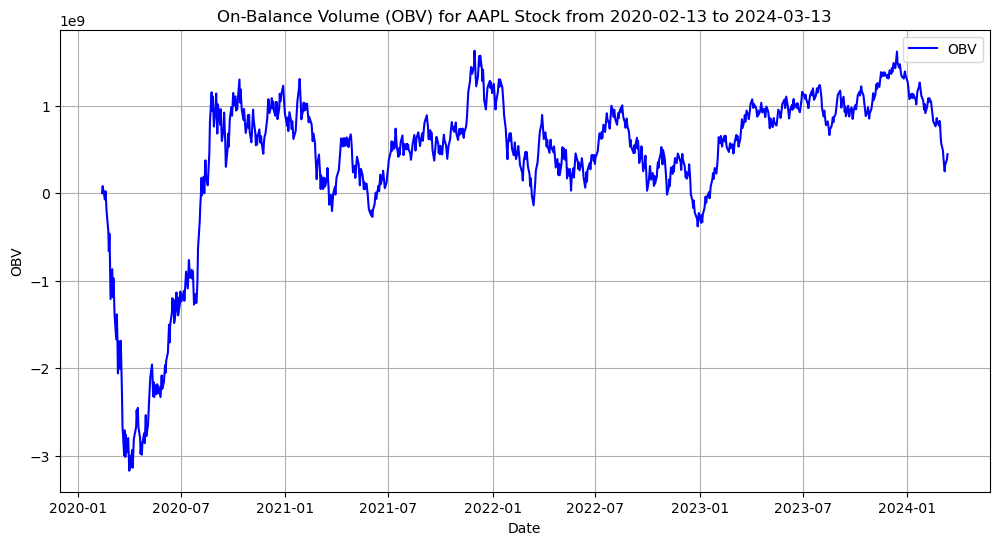

                          Date        OBV
0    2020-02-13 00:00:00+00:00          0
1    2020-02-14 00:00:00+00:00   80113600
2    2020-02-18 00:00:00+00:00  -72417600
3    2020-02-19 00:00:00+00:00   21566400
4    2020-02-20 00:00:00+00:00  -78999600
...                        ...        ...
1021 2024-03-06 00:00:00+00:00  320582100
1022 2024-03-07 00:00:00+00:00  248817000
1023 2024-03-08 00:00:00+00:00  324931600
1024 2024-03-11 00:00:00+00:00  385071100
1025 2024-03-12 00:00:00+00:00  444896500

[1026 rows x 2 columns]


In [137]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

class StockOBV:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None

    def download_data(self):
        """Download historical stock data."""
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_obv(self):
        """Calculate On-Balance Volume (OBV)."""
        if self.data is not None:
            # Calculate daily price change
            price_change = self.data['Close'].diff()

            # Calculate OBV
            self.data['OBV'] = (price_change > 0).astype(int) * self.data['Volume'] - (price_change < 0).astype(int) * self.data['Volume']
            self.data['OBV'] = self.data['OBV'].cumsum()  # Cumulative sum to get OBV
        else:
            raise ValueError("Data not downloaded. Please call download_data() first.")

    def get_obv_data(self):
        """Return a DataFrame of dates and their corresponding OBV values."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        # Create a DataFrame with the date and OBV values
        obv_data = self.data[['OBV']].dropna().reset_index()
        obv_data.columns = ['Date', 'OBV']  # Rename columns for clarity

        return obv_data

    def plot_obv(self):
        """Plot the OBV along with the closing price."""
        if 'OBV' not in self.data.columns:
            raise ValueError("OBV not calculated. Please call calculate_obv() first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, self.data['OBV'], label='OBV', color='blue')
        plt.title(f"On-Balance Volume (OBV) for {self.ticker} Stock from {self.start_date} to {self.end_date}")
        plt.xlabel("Date")
        plt.ylabel("OBV")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize the StockOBV class
    stock_obv = StockOBV(ticker="AAPL", start_date="2020-02-13", end_date="2024-03-13")

    # Download data, calculate OBV, and plot
    stock_obv.download_data()
    stock_obv.calculate_obv()
    stock_obv.plot_obv()

    # Get OBV data for further analysis
    obv_data = stock_obv.get_obv_data()
    print(obv_data)  # Print or save the OBV data as needed

In [138]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

class StockPlotter:
    def __init__(self, ticker, start_date, end_date, data):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = data

    def plot_rsi(self):
        """Plot the RSI along with overbought and oversold lines and stock price overlay."""
        if 'RSI' not in self.data.columns:
            raise ValueError("RSI not calculated. Please calculate RSI before plotting.")

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plotting RSI
        ax1.plot(self.data.index, self.data['RSI'], label='RSI', color='blue')
        ax1.axhline(30, color='red', linestyle='dotted', linewidth=1, label='Oversold (30)')
        ax1.axhline(70, color='green', linestyle='dotted', linewidth=1, label='Overbought (70)')
        ax1.set_ylim(0, 100)
        ax1.set_ylabel("RSI")
        ax1.set_title(f"RSI and Stock Price for {self.ticker} from {self.start_date} to {self.end_date}")
        ax1.legend(loc="upper left")
        ax1.grid()

        # Overlaying stock price
        ax2 = ax1.twinx()  # Secondary y-axis for stock price
        ax2.plot(self.data.index, self.data['Close'], label='Stock Price', color='black', alpha=0.5)
        ax2.set_ylabel("Stock Price")
        ax2.legend(loc="upper right")

        plt.show()

    def plot_macd(self):
        """Plot the MACD and signal line with stock price overlay using a secondary y-axis."""
        if 'MACD' not in self.data.columns or 'Signal_Line' not in self.data.columns:
            raise ValueError("MACD not calculated. Please calculate MACD before plotting.")

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Add MACD line (on primary y-axis)
        ax1.plot(self.data.index, self.data['MACD'], label='MACD', color='blue')

        # Add Signal Line (on primary y-axis)
        ax1.plot(self.data.index, self.data['Signal_Line'], label='Signal Line', color='orange')

        # Add horizontal line at zero (on primary y-axis)
        ax1.axhline(0, color='black', linestyle='dashed', linewidth=1)  # Zero line

        # Configure primary y-axis
        ax1.set_title(f"MACD and Stock Price for {self.ticker} from {self.start_date} to {self.end_date}")
        ax1.set_ylabel("MACD")
        ax1.legend(loc="upper left")
        ax1.grid()

        # Overlaying stock price on secondary y-axis
        ax2 = ax1.twinx()  # Secondary y-axis for stock price
        ax2.plot(self.data.index, self.data['Close'], label='Stock Price', color='black', alpha=0.5)
        ax2.set_ylabel("Stock Price")
        ax2.legend(loc="upper right")

        plt.show()

In [139]:
#2/ : import yfinance as yf
import pandas as pd
#from stock_plotter import StockPlotter  # Import the StockPlotter class

class StockAnalysis:
    def __init__(self, ticker: str, start_date: str, end_date: str):
        """
        Initialize StockAnalysis with a ticker symbol, start date, and end date.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.plotter = StockPlotter(ticker, start_date, end_date, self.data)  # Initialize the plotter

    def download_data(self) -> None:
        """
        Download historical stock data with a buffer for indicators.
        """
        # 26 days buffer to ensure initial values stabilize, especially for MACD
        buffer_days = 26
        start_with_buffer = pd.to_datetime(self.start_date) - pd.Timedelta(days=buffer_days)
        self.data = yf.download(self.ticker, start=start_with_buffer.strftime('%Y-%m-%d'), end=self.end_date)

        # Update plotter data
        self.plotter.data = self.data  

    def calculate_rsi(self, period: int = 14) -> None:
        """
        Calculate the Relative Strength Index (RSI) for the stock data.
        """
        if self.data is None:
            raise ValueError("Data not downloaded. Please call download_data() first.")

        delta = self.data['Close'].diff()
        gains = delta.where(delta > 0, 0)
        losses = -delta.where(delta < 0, 0)

        avg_gain = gains.ewm(span=period, min_periods=period).mean()
        avg_loss = losses.ewm(span=period, min_periods=period).mean()

        rs = avg_gain / avg_loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

    def calculate_macd(self, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> None:
        """
        Calculate the Moving Average Convergence Divergence (MACD) and the Signal Line.
        """
        if self.data is None:
            raise ValueError("Data not downloaded. Please call download_data() first.")

        # Calculating the short and long Exponential Moving Averages (EMAs)
        self.data['Short_EMA'] = self.data['Close'].ewm(span=short_window, adjust=False).mean()
        self.data['Long_EMA'] = self.data['Close'].ewm(span=long_window, adjust=False).mean()

        # Calculate MACD and Signal Line
        self.data['MACD'] = self.data['Short_EMA'] - self.data['Long_EMA']
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=signal_window, adjust=False).mean()

        # Remove the buffer rows to avoid misleading initial values
        self.data = self.data.loc[self.start_date:]

    def get_rsi_data(self) -> pd.DataFrame:
        """
        Return a DataFrame of dates and their corresponding RSI values.
        """
        if 'RSI' not in self.data.columns:
            raise ValueError("RSI not calculated. Please call calculate_rsi() first.")

        rsi_data = self.data[['RSI']].dropna().reset_index()
        rsi_data.columns = ['Date', 'RSI']
        return rsi_data

    def get_macd_data(self) -> pd.DataFrame:
        """
        Return a DataFrame of dates and their corresponding MACD and Signal Line values.
        """
        if 'MACD' not in self.data.columns or 'Signal_Line' not in self.data.columns:
            raise ValueError("MACD not calculated. Please call calculate_macd() first.")

        macd_data = self.data[['MACD', 'Signal_Line']].dropna().reset_index()
        macd_data.columns = ['Date', 'MACD', 'Signal Line']
        return macd_data

In [140]:

# Example usage
if __name__ == "__main__":
    stock_analysis = StockAnalysis(ticker="RBLX", start_date="2023-02-13", end_date="2025-11-02")
    stock_analysis.download_data()

    # Calculate indicators
    stock_analysis.calculate_rsi(period=14)
    stock_analysis.calculate_macd()

    # Plot RSI and MACD
    #stock_analysis.plotter.plot_rsi()
    #stock_analysis.plotter.plot_macd()

[*********************100%***********************]  1 of 1 completed


In [141]:
# Get RSI and MACD data for further analysis
rsi_data = stock_analysis.get_rsi_data()
print("RSI Data:\n", rsi_data)

macd_data = stock_analysis.get_macd_data()
print("MACD Data:\n", macd_data)
    
obv_data = stock_obv.get_obv_data()
print(obv_data)  # Print or save the OBV data as needed

RSI Data:
                          Date        RSI
0   2023-02-13 00:00:00+00:00  33.282317
1   2023-02-14 00:00:00+00:00  43.610196
2   2023-02-15 00:00:00+00:00  76.059969
3   2023-02-16 00:00:00+00:00  68.780104
4   2023-02-17 00:00:00+00:00  57.374757
..                        ...        ...
429 2024-10-28 00:00:00+00:00  60.570173
430 2024-10-29 00:00:00+00:00  63.998557
431 2024-10-30 00:00:00+00:00  69.269552
432 2024-10-31 00:00:00+00:00  91.771968
433 2024-11-01 00:00:00+00:00  89.309445

[434 rows x 2 columns]
MACD Data:
                          Date      MACD  Signal Line
0   2023-02-13 00:00:00+00:00  0.104705     0.434950
1   2023-02-14 00:00:00+00:00  0.017087     0.351378
2   2023-02-15 00:00:00+00:00  0.698901     0.420882
3   2023-02-16 00:00:00+00:00  1.105463     0.557799
4   2023-02-17 00:00:00+00:00  1.196012     0.685441
..                        ...       ...          ...
429 2024-10-28 00:00:00+00:00 -0.481599    -0.666048
430 2024-10-29 00:00:00+00:00 -0.3616

In [146]:
data_to_upload = {
    "ticker": str(stock_analysis.ticker),
    "date_range": {
        "start": str(stock_analysis.start_date),
        "end": str(stock_analysis.end_date)
    },
    "indicators": {
        "RSI": str(rsi_data.to_dict(orient='records')),
        "MACD":str( macd_data.to_dict(orient='records')),
        "OBV": str(obv_data.to_dict(orient='records'))
    }
}



In [147]:
# Convertir en JSON
json_data = json.dumps(data_to_upload)

In [148]:

# Nom de votre bucket S3
bucket_name = bucket_name

file_name = 'json_data.json'  # ou un autre nom pour éviter l'écrasement


NameError: name 's3' is not defined

In [76]:
# Define the S3 configuration for your data source
s3_configuration = {
    'bucketArn': bucket_arn,
    'inclusionPrefixes': [kb_key]  
}

# Define the data source configuration
data_source_configuration = {
    's3Configuration': s3_configuration,
    'type': 'S3'
}

knowledge_base_id = kb_obj["knowledgeBase"]["knowledgeBaseId"]
knowledge_base_arn = kb_obj["knowledgeBase"]["knowledgeBaseArn"]

chunking_strategy_configuration = {
    "chunkingStrategy": "FIXED_SIZE",
    "fixedSizeChunkingConfiguration": {
        "maxTokens": 512,
        "overlapPercentage": 20
    }
}

# Create the data source
try:
    # ensure that the KB is created and available
    time.sleep(45)
    data_source_response = bedrock_agent_client.create_data_source(
        knowledgeBaseId=knowledge_base_id,
        name=data_source_name,
        description='DataSource for the bedrock documentation',
        dataSourceConfiguration=data_source_configuration,
        vectorIngestionConfiguration = {
            "chunkingConfiguration": chunking_strategy_configuration
        }
    )

    # Pretty print the response
    pprint.pprint(data_source_response)

except Exception as e:
    print(f"Error occurred: {e}")

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '623',
                                      'content-type': 'application/json',
                                      'date': 'Sun, 03 Nov 2024 15:19:25 GMT',
                                      'x-amz-apigw-id': 'ArQjoE56vHcEtnw=',
                                      'x-amzn-requestid': '025df51e-e0cd-4901-a76b-26b82d062f86',
                                      'x-amzn-trace-id': 'Root=1-6727947d-0df0b04724cc1a8045a4b622'},
                      'HTTPStatusCode': 200,
                      'RequestId': '025df51e-e0cd-4901-a76b-26b82d062f86',
                      'RetryAttempts': 0},
 'dataSource': {'createdAt': datetime.datetime(2024, 11, 3, 15, 19, 25, 263281, tzinfo=tzlocal()),
                'dataDeletionPolicy': 'DELETE',
                'dataSourceConfiguration': {'s3Configuration': {'bucketArn': 'arn:aws:s3:::my-data-bucket-2024',
                   

In [152]:
# Télécharger le fichier JSON dans S3
#s3_configuration.put_object(Bucket=bucket_name, Key=file_name, Body=json_data)

#s3_configuration.upload_file('/tmp/hello.txt', Bucket=bucket_name, Body=json_data)
#print(f"Les données ont été ajoutées dans le bucket {bucket_name} sous le nom de fichier {file_name}.")

AttributeError: 'dict' object has no attribute 'upload_file'

In [153]:


def lambda_handler(event, context):

    bucket = 'mybucket'
    key = 'id.txt'
    id = None

    # Write id to S3
    s3_configuration.put_object(Body=json_data, Bucket=bucket_name,Key=file_name)


In [154]:
# Start an ingestion job
data_source_id = data_source_response["dataSource"]["dataSourceId"]
start_job_response = bedrock_agent_client.start_ingestion_job(
    knowledgeBaseId=knowledge_base_id, 
    dataSourceId=data_source_id
)

In [155]:
# Create IAM policies for agent
bedrock_agent_bedrock_allow_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AmazonBedrockAgentBedrockFoundationModelPolicy",
            "Effect": "Allow",
            "Action": "bedrock:InvokeModel",
            "Resource": [
                f"arn:aws:bedrock:{region}::foundation-model/{model_id}"
            ]
        }
    ]
}

bedrock_policy_json = json.dumps(bedrock_agent_bedrock_allow_policy_statement)

agent_bedrock_policy = iam_client.create_policy(
    PolicyName=bedrock_agent_bedrock_allow_policy_name,
    PolicyDocument=bedrock_policy_json
)

EntityAlreadyExistsException: An error occurred (EntityAlreadyExists) when calling the CreatePolicy operation: A policy called bda-bedrock-allow-1730646923 already exists. Duplicate names are not allowed.

In [ ]:
bedrock_agent_kb_retrival_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "bedrock:Retrieve"
            ],
            "Resource": [
                knowledge_base_arn
            ]
        }
    ]
}
bedrock_agent_kb_json = json.dumps(bedrock_agent_kb_retrival_policy_statement)
agent_kb_schema_policy = iam_client.create_policy(
    PolicyName=bedrock_agent_kb_allow_policy_name,
    Description=f"Policy to allow agent to retrieve documents from knowledge base.",
    PolicyDocument=bedrock_agent_kb_json
)

In [ ]:
# Create IAM Role for the agent and attach IAM policies
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [{
          "Effect": "Allow",
          "Principal": {
            "Service": "bedrock.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
    }]
}

assume_role_policy_document_json = json.dumps(assume_role_policy_document)
agent_role = iam_client.create_role(
    RoleName=agent_role_name,
    AssumeRolePolicyDocument=assume_role_policy_document_json
)

# Pause to make sure role is created
time.sleep(10)
    
iam_client.attach_role_policy(
    RoleName=agent_role_name,
    PolicyArn=agent_bedrock_policy['Policy']['Arn']
)


iam_client.attach_role_policy(
    RoleName=agent_role_name,
    PolicyArn=agent_kb_schema_policy['Policy']['Arn']
)

In [156]:
# Create Agent
response = bedrock_agent_client.create_agent(
    agentName=agent_name,
    agentResourceRoleArn=agent_role['Role']['Arn'],
    description="Agent supporting Amazon Bedrock Developers.",
    idleSessionTTLInSeconds=1800,
    foundationModel=model_id,
    instruction=agent_instruction,
)

ConflictException: An error occurred (ConflictException) when calling the CreateAgent operation: Could not perform Create operation, since the bedrock-docs-kb-agents1730646923 (id: XXBYAUZFJL) with the same name bedrock-docs-kb-agents1730646923 already exists

In [ ]:
agent_id = response['agent']['agentId']
agent_id

In [157]:
agent_kb_description = bedrock_agent_client.associate_agent_knowledge_base(
    agentId=agent_id,
    agentVersion='DRAFT',
    description=f'Use the information in the {kb_name} knowledge base to provide accurate responses to the questions about Amazon Bedrock.',
    knowledgeBaseId=knowledge_base_id 
)

In [158]:
agent_prepare = bedrock_agent_client.prepare_agent(agentId=agent_id)
agent_prepare

{'ResponseMetadata': {'RequestId': 'd4773bbb-8998-4ee7-9518-4d2e32ef9a5f',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 15:41:06 GMT',
   'content-type': 'application/json',
   'content-length': '119',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd4773bbb-8998-4ee7-9518-4d2e32ef9a5f',
   'x-amz-apigw-id': 'ArTu3FRhPHcEBpg=',
   'x-amzn-trace-id': 'Root=1-67279991-130833d701848c652297ffd9'},
  'RetryAttempts': 0},
 'agentId': 'XXBYAUZFJL',
 'agentStatus': 'PREPARING',
 'agentVersion': 'DRAFT',
 'preparedAt': datetime.datetime(2024, 11, 3, 15, 41, 6, 43434, tzinfo=tzlocal())}

In [159]:
# Pause to make sure agent is prepared
time.sleep(30)
agent_alias = bedrock_agent_client.create_agent_alias(
    agentId=agent_id,
    agentAliasName=agent_alias_name
)
# Pause to make sure agent alias is ready
time.sleep(30)

ConflictException: An error occurred (ConflictException) when calling the CreateAgentAlias operation: Could not perform Create operation, since the bedrock-docs-alias1730646923 (id: IUXSINUTVY) with the same name bedrock-docs-alias1730646923 already exists

In [160]:
agent_alias


{'ResponseMetadata': {'RequestId': '47d0e7d1-6070-42be-aa31-510814c50eac',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 15:21:31 GMT',
   'content-type': 'application/json',
   'content-length': '354',
   'connection': 'keep-alive',
   'x-amzn-requestid': '47d0e7d1-6070-42be-aa31-510814c50eac',
   'x-amz-apigw-id': 'ArQ3RGXCPHcEsfw=',
   'x-amzn-trace-id': 'Root=1-672794fa-1c698a7110e4e5f251eb4b93'},
  'RetryAttempts': 0},
 'agentAlias': {'agentAliasArn': 'arn:aws:bedrock:us-west-2:939490215743:agent-alias/XXBYAUZFJL/IUXSINUTVY',
  'agentAliasId': 'IUXSINUTVY',
  'agentAliasName': 'bedrock-docs-alias1730646923',
  'agentAliasStatus': 'CREATING',
  'agentId': 'XXBYAUZFJL',
  'createdAt': datetime.datetime(2024, 11, 3, 15, 21, 31, 90875, tzinfo=tzlocal()),
  'routingConfiguration': [{}],
  'updatedAt': datetime.datetime(2024, 11, 3, 15, 21, 31, 90875, tzinfo=tzlocal())}}

In [161]:
# Extract the agentAliasId from the response
agent_alias_id = agent_alias['agentAlias']['agentAliasId']

## create a random id for session initiator id
session_id:str = str(uuid.uuid1())
enable_trace:bool = True
end_session:bool = False



In [162]:
# invoke the agent API
agentResponse = bedrock_agent_runtime_client.invoke_agent(
    inputText="par defaut ",
    agentId=agent_id,
    agentAliasId=agent_alias_id, 
    sessionId=session_id,
    enableTrace=enable_trace, 
    endSession= end_session
)

logger.info(pprint.pprint(agentResponse))

[2024-11-03 15:41:49,212] p2569 {2262335159.py:11} INFO - None


{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-type': 'application/vnd.amazon.eventstream',
                                      'date': 'Sun, 03 Nov 2024 15:41:49 GMT',
                                      'transfer-encoding': 'chunked',
                                      'x-amz-bedrock-agent-session-id': '2339800c-99fa-11ef-9dc3-b2ece9986ad5',
                                      'x-amzn-bedrock-agent-content-type': 'application/json',
                                      'x-amzn-requestid': '77b1c812-d6bf-425e-aee9-4ad14ab73e65'},
                      'HTTPStatusCode': 200,
                      'RequestId': '77b1c812-d6bf-425e-aee9-4ad14ab73e65',
                      'RetryAttempts': 0},
 'completion': <botocore.eventstream.EventStream object at 0x7f52edf66e50>,
 'contentType': 'application/json',
 'sessionId': '2339800c-99fa-11ef-9dc3-b2ece9986ad5'}


In [163]:
%%time
event_stream = agentResponse['completion']
try:
    for event in event_stream:        
        if 'chunk' in event:
            data = event['chunk']['bytes']
            logger.info(f"Final answer ->\n{data.decode('utf8')}")
            agent_answer = data.decode('utf8')
            end_event_received = True
            # End event indicates that the request finished successfully
        elif 'trace' in event:
            logger.info(json.dumps(event['trace'], indent=2))
        else:
            raise Exception("unexpected event.", event)
except Exception as e:
    raise Exception("unexpected event.", e)

[2024-11-03 15:41:50,180] p2569 {<timed exec>:11} INFO - {
  "agentAliasId": "IUXSINUTVY",
  "agentId": "XXBYAUZFJL",
  "agentVersion": "1",
  "sessionId": "2339800c-99fa-11ef-9dc3-b2ece9986ad5",
  "trace": {
    "orchestrationTrace": {
      "modelInvocationInput": {
        "inferenceConfiguration": {
          "maximumLength": 2048,
          "stopSequences": [
            "</function_calls>",
            "</answer>",
            "</error>"
          ],
          "temperature": 0.0,
          "topK": 250,
          "topP": 1.0
        },
        "text": "{\"system\":\"**Pr\u00e9prompt pour le Chatbot Financier****1. Description de la firme :**Vous fournirez un aper\u00e7u complet de la firme, y compris son secteur d'activit\u00e9, ses services et sa position sur le march\u00e9.**2. Contexte de la t\u00e2che :**Vous agirez en tant qu'assistant financier qui aide les utilisateurs \u00e0 rassembler des informations d\u00e9taill\u00e9es sur une entreprise sp\u00e9cifique.**3. Contexte t

CPU times: user 10.7 ms, sys: 41 μs, total: 10.8 ms
Wall time: 1.51 s


In [164]:
# And here is the response if you just want to see agent's reply
print(agent_answer)


Désolé, je n'ai pas reçu de question spécifique de votre part. Je suis un assistant virtuel conçu pour fournir des informations détaillées sur les entreprises. Pour commencer, veuillez me poser une question sur une entreprise particulière ou me fournir le nom d'une entreprise sur laquelle vous souhaitez obtenir des informations.



In [165]:
def simple_agent_invoke(input_text, agent_id, agent_alias_id, session_id=None, enable_trace=False, end_session=False):
    if session_id is None:
        session_id:str = str(uuid.uuid1())

    agentResponse = bedrock_agent_runtime_client.invoke_agent(
        inputText=input_text,
        agentId=agent_id,
        agentAliasId=agent_alias_id, 
        sessionId=session_id,
        enableTrace=enable_trace, 
        endSession= end_session
    )
    logger.info(pprint.pprint(agentResponse))
    
    agent_answer = ''
    event_stream = agentResponse['completion']
    try:
        for event in event_stream:        
            if 'chunk' in event:
                data = event['chunk']['bytes']
                logger.info(f"Final answer ->\n{data.decode('utf8')}")
                agent_answer = data.decode('utf8')
                end_event_received = True
                # End event indicates that the request finished successfully
            elif 'trace' in event:
                logger.info(json.dumps(event['trace'], indent=2))
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)
    return agent_answer

In [166]:
simple_agent_invoke("quel est le futur de CN ?", agent_id, agent_alias_id, session_id)


[2024-11-03 15:41:58,872] p2569 {321621934.py:13} INFO - None


{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-type': 'application/vnd.amazon.eventstream',
                                      'date': 'Sun, 03 Nov 2024 15:41:58 GMT',
                                      'transfer-encoding': 'chunked',
                                      'x-amz-bedrock-agent-session-id': '2339800c-99fa-11ef-9dc3-b2ece9986ad5',
                                      'x-amzn-bedrock-agent-content-type': 'application/json',
                                      'x-amzn-requestid': 'aeba362d-50aa-4332-a885-ed9b0fa88827'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'aeba362d-50aa-4332-a885-ed9b0fa88827',
                      'RetryAttempts': 0},
 'completion': <botocore.eventstream.EventStream object at 0x7f52ec651390>,
 'contentType': 'application/json',
 'sessionId': '2339800c-99fa-11ef-9dc3-b2ece9986ad5'}


[2024-11-03 15:42:14,203] p2569 {321621934.py:21} INFO - Final answer ->
Bien que je n'aie pas accès à des informations détaillées sur l'entreprise CN (Canadien National), voici quelques réflexions générales sur son avenir :

CN est l'une des plus grandes compagnies de chemin de fer en Amérique du Nord. Son avenir dépendra en grande partie de la demande continue pour le transport ferroviaire de marchandises dans les secteurs clés comme les ressources naturelles, les produits manufacturés et les produits de consommation.

Quelques facteurs clés qui influenceront l'avenir de CN incluent :

- L'évolution de l'économie et des échanges commerciaux, en particulier entre le Canada, les États-Unis et le reste du monde.
- Les investissements continus dans l'infrastructure ferroviaire et l'efficacité opérationnelle pour rester compétitifs.
- L'adoption de nouvelles technologies comme l'automatisation et l'intelligence artificielle dans le secteur ferroviaire.
- La transition vers une économie pl

"Bien que je n'aie pas accès à des informations détaillées sur l'entreprise CN (Canadien National), voici quelques réflexions générales sur son avenir :\n\nCN est l'une des plus grandes compagnies de chemin de fer en Amérique du Nord. Son avenir dépendra en grande partie de la demande continue pour le transport ferroviaire de marchandises dans les secteurs clés comme les ressources naturelles, les produits manufacturés et les produits de consommation.\n\nQuelques facteurs clés qui influenceront l'avenir de CN incluent :\n\n- L'évolution de l'économie et des échanges commerciaux, en particulier entre le Canada, les États-Unis et le reste du monde.\n- Les investissements continus dans l'infrastructure ferroviaire et l'efficacité opérationnelle pour rester compétitifs.\n- L'adoption de nouvelles technologies comme l'automatisation et l'intelligence artificielle dans le secteur ferroviaire.\n- La transition vers une économie plus durable et les efforts pour réduire l'empreinte environnemen